In [1]:
import pandas as pd
import numpy as np

# Modelo Recurrentes con Embeddings a nivel de caracter

In [3]:
df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [4]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


# Canonical_smiles To secuence

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()

In [7]:
X = df['canonical_smiles']
y = df['pIC50']

In [8]:
tokenizer = Tokenizer(num_words = None, oov_token='UNK', filters = '', char_level = True, lower = False)

In [9]:
tokenizer.fit_on_texts(X)

In [10]:
sequences = tokenizer.texts_to_sequences(X)

In [11]:
print(X[0])
print(sequences[0])

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
[3, 3, 7, 2, 6, 15, 15, 4, 18, 2, 8, 2, 2, 2, 2, 4, 7, 3, 2, 11, 2, 2, 2, 2, 2, 11, 5, 2, 8, 5, 2, 4, 10, 7, 5, 25, 6]


In [12]:
print(len(X[0]))
print(len(sequences[0]))

37
37


In [13]:
X_seq_pad = pad_sequences(sequences, maxlen = len(X[max_len_idx]), padding = 'pre' )

In [14]:
X_seq_pad[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  3,  7,  2,  6, 15, 15,  4, 18,  2,  8,  2,  2,  2,  2,  4,  7,
        3,  2, 11,  2,  2,  2,  2,  2, 11,  5,  2,  8,  5,  2,  4, 10,  7,
        5, 25,  6], dtype=int32)

In [ ]:
# Implementar tokenización y guardar en X_seq_pad el dataset tokenizado

# Split

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_pad, y, test_size=0.2, random_state=42)

In [40]:
len(X_train), len(y_train), len(X_test)

(4082, 4082, 1021)

In [41]:
X_train.shape

(4082, 207)

In [42]:
y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5098    3.575118
5099    6.130768
5100    6.292430
5101    3.903090
5102    4.000000
Name: pIC50, Length: 5103, dtype: float64

# Network Model

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

In [44]:
# Métrica

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [45]:
# vocab_size = # Completar largo del vocabulario
vocab_size = len(tokenizer.word_index)

In [46]:
vocab_size

39

In [47]:
max_sequence_len = len(X[max_len_idx])

# Modelo en keras de LSTM


In [54]:
rnn_neurons_1 = 100
rnn_neurons_2 = 50
input_shape = (max_sequence_len, 1)
dropout_p = 0.2

In [60]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1, output_dim = 64, input_length=max_sequence_len))
model.add(LSTM(rnn_neurons_1, return_sequences = True, dropout=dropout_p, recurrent_dropout=dropout_p))
model.add(LSTM(rnn_neurons_2,  dropout=dropout_p, recurrent_dropout=dropout_p))

model.add(Dense(1))


In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 207, 64)           2560      
                                                                 
 lstm_8 (LSTM)               (None, 207, 100)          66000     
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 98,811
Trainable params: 98,811
Non-trainable params: 0
_________________________________________________________________


In [63]:
mcp = ModelCheckpoint('models_4/best_model_{epoch}', save_best_only=True, save_format="h5")

In [64]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [65]:
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test), callbacks=[mcp])

Epoch 1/150
32/32 [==============================] - ETA: 0s - loss: 13.0609 - R2: -3.7646INFO:tensorflow:Assets written to: models_4/best_model_1/assets


INFO:tensorflow:Assets written to: models_4/best_model_1/assets


32/32 [==============================] - 58s 1s/step - loss: 13.0609 - R2: -3.7646 - val_loss: 3.0602 - val_R2: -0.0734
Epoch 2/150
32/32 [==============================] - ETA: 0s - loss: 2.8141 - R2: -0.0238INFO:tensorflow:Assets written to: models_4/best_model_2/assets


INFO:tensorflow:Assets written to: models_4/best_model_2/assets


32/32 [==============================] - 34s 1s/step - loss: 2.8141 - R2: -0.0238 - val_loss: 2.9031 - val_R2: -0.0137
Epoch 3/150
32/32 [==============================] - ETA: 0s - loss: 2.8037 - R2: -0.0150INFO:tensorflow:Assets written to: models_4/best_model_3/assets


INFO:tensorflow:Assets written to: models_4/best_model_3/assets


32/32 [==============================] - 35s 1s/step - loss: 2.8037 - R2: -0.0150 - val_loss: 2.8913 - val_R2: -0.0090
Epoch 4/150
32/32 [==============================] - ETA: 0s - loss: 2.7905 - R2: -0.0103INFO:tensorflow:Assets written to: models_4/best_model_4/assets


INFO:tensorflow:Assets written to: models_4/best_model_4/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7905 - R2: -0.0103 - val_loss: 2.8844 - val_R2: -0.0059
Epoch 5/150
32/32 [==============================] - ETA: 0s - loss: 2.7984 - R2: -0.0118INFO:tensorflow:Assets written to: models_4/best_model_5/assets


INFO:tensorflow:Assets written to: models_4/best_model_5/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7984 - R2: -0.0118 - val_loss: 2.8836 - val_R2: -0.0057
Epoch 6/150
32/32 [==============================] - ETA: 0s - loss: 2.7937 - R2: -0.0109INFO:tensorflow:Assets written to: models_4/best_model_6/assets


INFO:tensorflow:Assets written to: models_4/best_model_6/assets


32/32 [==============================] - 34s 1s/step - loss: 2.7937 - R2: -0.0109 - val_loss: 2.8828 - val_R2: -0.0054
Epoch 7/150
32/32 [==============================] - 29s 922ms/step - loss: 2.7964 - R2: -0.0100 - val_loss: 2.8835 - val_R2: -0.0059
Epoch 8/150
32/32 [==============================] - ETA: 0s - loss: 2.7843 - R2: -0.0050INFO:tensorflow:Assets written to: models_4/best_model_8/assets


INFO:tensorflow:Assets written to: models_4/best_model_8/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7843 - R2: -0.0050 - val_loss: 2.8804 - val_R2: -0.0047
Epoch 9/150
32/32 [==============================] - ETA: 0s - loss: 2.7911 - R2: -0.0092INFO:tensorflow:Assets written to: models_4/best_model_9/assets


INFO:tensorflow:Assets written to: models_4/best_model_9/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7911 - R2: -0.0092 - val_loss: 2.8769 - val_R2: -0.0033
Epoch 10/150
32/32 [==============================] - 30s 923ms/step - loss: 2.7947 - R2: -0.0105 - val_loss: 2.8892 - val_R2: -0.0087
Epoch 11/150
32/32 [==============================] - 29s 922ms/step - loss: 2.7772 - R2: -0.0056 - val_loss: 2.8811 - val_R2: -0.0056
Epoch 12/150
32/32 [==============================] - ETA: 0s - loss: 2.7802 - R2: -0.0052INFO:tensorflow:Assets written to: models_4/best_model_12/assets


INFO:tensorflow:Assets written to: models_4/best_model_12/assets


32/32 [==============================] - 34s 1s/step - loss: 2.7802 - R2: -0.0052 - val_loss: 2.8577 - val_R2: 0.0036
Epoch 13/150
32/32 [==============================] - ETA: 0s - loss: 2.7729 - R2: -5.0201e-04INFO:tensorflow:Assets written to: models_4/best_model_13/assets


INFO:tensorflow:Assets written to: models_4/best_model_13/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7729 - R2: -5.0201e-04 - val_loss: 2.8439 - val_R2: 0.0091
Epoch 14/150
32/32 [==============================] - ETA: 0s - loss: 2.7478 - R2: 0.0077INFO:tensorflow:Assets written to: models_4/best_model_14/assets


INFO:tensorflow:Assets written to: models_4/best_model_14/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7478 - R2: 0.0077 - val_loss: 2.8246 - val_R2: 0.0160
Epoch 15/150
32/32 [==============================] - ETA: 0s - loss: 2.7399 - R2: 0.0096INFO:tensorflow:Assets written to: models_4/best_model_15/assets


INFO:tensorflow:Assets written to: models_4/best_model_15/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7399 - R2: 0.0096 - val_loss: 2.8033 - val_R2: 0.0237
Epoch 16/150
32/32 [==============================] - ETA: 0s - loss: 2.7322 - R2: 0.0098INFO:tensorflow:Assets written to: models_4/best_model_16/assets


INFO:tensorflow:Assets written to: models_4/best_model_16/assets


32/32 [==============================] - 34s 1s/step - loss: 2.7322 - R2: 0.0098 - val_loss: 2.7864 - val_R2: 0.0295
Epoch 17/150
32/32 [==============================] - ETA: 0s - loss: 2.7161 - R2: 0.0171INFO:tensorflow:Assets written to: models_4/best_model_17/assets


INFO:tensorflow:Assets written to: models_4/best_model_17/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7161 - R2: 0.0171 - val_loss: 2.7704 - val_R2: 0.0353
Epoch 18/150
32/32 [==============================] - 29s 923ms/step - loss: 2.7207 - R2: 0.0130 - val_loss: 2.8005 - val_R2: 0.0255
Epoch 19/150
32/32 [==============================] - 30s 929ms/step - loss: 2.7321 - R2: 0.0116 - val_loss: 2.7907 - val_R2: 0.0267
Epoch 20/150
32/32 [==============================] - 29s 921ms/step - loss: 2.7039 - R2: 0.0192 - val_loss: 2.7782 - val_R2: 0.0312
Epoch 21/150
32/32 [==============================] - ETA: 0s - loss: 2.7110 - R2: 0.0131INFO:tensorflow:Assets written to: models_4/best_model_21/assets


INFO:tensorflow:Assets written to: models_4/best_model_21/assets


32/32 [==============================] - 35s 1s/step - loss: 2.7110 - R2: 0.0131 - val_loss: 2.7519 - val_R2: 0.0414
Epoch 22/150
32/32 [==============================] - ETA: 0s - loss: 2.6989 - R2: 0.0242INFO:tensorflow:Assets written to: models_4/best_model_22/assets


INFO:tensorflow:Assets written to: models_4/best_model_22/assets


32/32 [==============================] - 34s 1s/step - loss: 2.6989 - R2: 0.0242 - val_loss: 2.7482 - val_R2: 0.0434
Epoch 23/150
32/32 [==============================] - 30s 924ms/step - loss: 2.6889 - R2: 0.0275 - val_loss: 2.7890 - val_R2: 0.0295
Epoch 24/150
32/32 [==============================] - 29s 920ms/step - loss: 2.7087 - R2: 0.0172 - val_loss: 2.8011 - val_R2: 0.0215
Epoch 25/150
32/32 [==============================] - ETA: 0s - loss: 2.6987 - R2: 0.0259INFO:tensorflow:Assets written to: models_4/best_model_25/assets


INFO:tensorflow:Assets written to: models_4/best_model_25/assets


32/32 [==============================] - 35s 1s/step - loss: 2.6987 - R2: 0.0259 - val_loss: 2.7282 - val_R2: 0.0507
Epoch 26/150
32/32 [==============================] - ETA: 0s - loss: 2.6801 - R2: 0.0301INFO:tensorflow:Assets written to: models_4/best_model_26/assets


INFO:tensorflow:Assets written to: models_4/best_model_26/assets


32/32 [==============================] - 35s 1s/step - loss: 2.6801 - R2: 0.0301 - val_loss: 2.7018 - val_R2: 0.0586
Epoch 27/150
32/32 [==============================] - 29s 922ms/step - loss: 2.6668 - R2: 0.0342 - val_loss: 2.7472 - val_R2: 0.0447
Epoch 28/150
32/32 [==============================] - ETA: 0s - loss: 2.6702 - R2: 0.0295INFO:tensorflow:Assets written to: models_4/best_model_28/assets


INFO:tensorflow:Assets written to: models_4/best_model_28/assets


32/32 [==============================] - 34s 1s/step - loss: 2.6702 - R2: 0.0295 - val_loss: 2.6816 - val_R2: 0.0659
Epoch 29/150
32/32 [==============================] - 30s 924ms/step - loss: 2.6079 - R2: 0.0579 - val_loss: 2.7001 - val_R2: 0.0568
Epoch 30/150
32/32 [==============================] - ETA: 0s - loss: 2.5895 - R2: 0.0641INFO:tensorflow:Assets written to: models_4/best_model_30/assets


INFO:tensorflow:Assets written to: models_4/best_model_30/assets


32/32 [==============================] - 35s 1s/step - loss: 2.5895 - R2: 0.0641 - val_loss: 2.6315 - val_R2: 0.0829
Epoch 31/150
32/32 [==============================] - ETA: 0s - loss: 2.5491 - R2: 0.0752INFO:tensorflow:Assets written to: models_4/best_model_31/assets


INFO:tensorflow:Assets written to: models_4/best_model_31/assets


32/32 [==============================] - 35s 1s/step - loss: 2.5491 - R2: 0.0752 - val_loss: 2.5383 - val_R2: 0.1171
Epoch 32/150
32/32 [==============================] - ETA: 0s - loss: 2.4852 - R2: 0.1016INFO:tensorflow:Assets written to: models_4/best_model_32/assets


INFO:tensorflow:Assets written to: models_4/best_model_32/assets


32/32 [==============================] - 35s 1s/step - loss: 2.4852 - R2: 0.1016 - val_loss: 2.4949 - val_R2: 0.1318
Epoch 33/150
32/32 [==============================] - ETA: 0s - loss: 2.4785 - R2: 0.1062INFO:tensorflow:Assets written to: models_4/best_model_33/assets


INFO:tensorflow:Assets written to: models_4/best_model_33/assets


32/32 [==============================] - 34s 1s/step - loss: 2.4785 - R2: 0.1062 - val_loss: 2.4839 - val_R2: 0.1362
Epoch 34/150
32/32 [==============================] - ETA: 0s - loss: 2.3684 - R2: 0.1403INFO:tensorflow:Assets written to: models_4/best_model_34/assets


INFO:tensorflow:Assets written to: models_4/best_model_34/assets


32/32 [==============================] - 35s 1s/step - loss: 2.3684 - R2: 0.1403 - val_loss: 2.4262 - val_R2: 0.1563
Epoch 35/150
32/32 [==============================] - ETA: 0s - loss: 2.2794 - R2: 0.1768INFO:tensorflow:Assets written to: models_4/best_model_35/assets


INFO:tensorflow:Assets written to: models_4/best_model_35/assets


32/32 [==============================] - 35s 1s/step - loss: 2.2794 - R2: 0.1768 - val_loss: 2.3447 - val_R2: 0.1855
Epoch 36/150
32/32 [==============================] - 29s 921ms/step - loss: 2.2426 - R2: 0.1857 - val_loss: 2.4536 - val_R2: 0.1452
Epoch 37/150
32/32 [==============================] - ETA: 0s - loss: 2.2389 - R2: 0.1880INFO:tensorflow:Assets written to: models_4/best_model_37/assets


INFO:tensorflow:Assets written to: models_4/best_model_37/assets


32/32 [==============================] - 35s 1s/step - loss: 2.2389 - R2: 0.1880 - val_loss: 2.2888 - val_R2: 0.2056
Epoch 38/150
32/32 [==============================] - ETA: 0s - loss: 2.1835 - R2: 0.2108INFO:tensorflow:Assets written to: models_4/best_model_38/assets


INFO:tensorflow:Assets written to: models_4/best_model_38/assets


32/32 [==============================] - 34s 1s/step - loss: 2.1835 - R2: 0.2108 - val_loss: 2.2457 - val_R2: 0.2202
Epoch 39/150
32/32 [==============================] - ETA: 0s - loss: 2.0979 - R2: 0.2434INFO:tensorflow:Assets written to: models_4/best_model_39/assets


INFO:tensorflow:Assets written to: models_4/best_model_39/assets


32/32 [==============================] - 35s 1s/step - loss: 2.0979 - R2: 0.2434 - val_loss: 2.1607 - val_R2: 0.2367
Epoch 40/150
32/32 [==============================] - 29s 920ms/step - loss: 2.1158 - R2: 0.2370 - val_loss: 2.1756 - val_R2: 0.2438
Epoch 41/150
32/32 [==============================] - 29s 922ms/step - loss: 2.0902 - R2: 0.2447 - val_loss: 2.2417 - val_R2: 0.2221
Epoch 42/150
32/32 [==============================] - ETA: 0s - loss: 2.0510 - R2: 0.2566INFO:tensorflow:Assets written to: models_4/best_model_42/assets


INFO:tensorflow:Assets written to: models_4/best_model_42/assets


32/32 [==============================] - 35s 1s/step - loss: 2.0510 - R2: 0.2566 - val_loss: 2.1110 - val_R2: 0.2683
Epoch 43/150
32/32 [==============================] - ETA: 0s - loss: 1.9842 - R2: 0.2845INFO:tensorflow:Assets written to: models_4/best_model_43/assets


INFO:tensorflow:Assets written to: models_4/best_model_43/assets


32/32 [==============================] - 35s 1s/step - loss: 1.9842 - R2: 0.2845 - val_loss: 2.1033 - val_R2: 0.2698
Epoch 44/150
32/32 [==============================] - 30s 924ms/step - loss: 1.9335 - R2: 0.3033 - val_loss: 2.1522 - val_R2: 0.2550
Epoch 45/150
32/32 [==============================] - ETA: 0s - loss: 1.9379 - R2: 0.2987INFO:tensorflow:Assets written to: models_4/best_model_45/assets


INFO:tensorflow:Assets written to: models_4/best_model_45/assets


32/32 [==============================] - 34s 1s/step - loss: 1.9379 - R2: 0.2987 - val_loss: 2.0028 - val_R2: 0.3045
Epoch 46/150
32/32 [==============================] - 30s 928ms/step - loss: 1.9014 - R2: 0.3134 - val_loss: 2.1235 - val_R2: 0.2594
Epoch 47/150
32/32 [==============================] - ETA: 0s - loss: 1.8905 - R2: 0.3142INFO:tensorflow:Assets written to: models_4/best_model_47/assets


INFO:tensorflow:Assets written to: models_4/best_model_47/assets


32/32 [==============================] - 35s 1s/step - loss: 1.8905 - R2: 0.3142 - val_loss: 1.9562 - val_R2: 0.3202
Epoch 48/150
32/32 [==============================] - 30s 925ms/step - loss: 1.8282 - R2: 0.3404 - val_loss: 1.9576 - val_R2: 0.3177
Epoch 49/150
32/32 [==============================] - ETA: 0s - loss: 1.8850 - R2: 0.3173INFO:tensorflow:Assets written to: models_4/best_model_49/assets


INFO:tensorflow:Assets written to: models_4/best_model_49/assets


32/32 [==============================] - 35s 1s/step - loss: 1.8850 - R2: 0.3173 - val_loss: 1.9293 - val_R2: 0.3221
Epoch 50/150
32/32 [==============================] - 30s 923ms/step - loss: 1.8015 - R2: 0.3475 - val_loss: 1.9429 - val_R2: 0.3120
Epoch 51/150
32/32 [==============================] - ETA: 0s - loss: 1.7996 - R2: 0.3474INFO:tensorflow:Assets written to: models_4/best_model_51/assets


INFO:tensorflow:Assets written to: models_4/best_model_51/assets


32/32 [==============================] - 35s 1s/step - loss: 1.7996 - R2: 0.3474 - val_loss: 1.8142 - val_R2: 0.3596
Epoch 52/150
32/32 [==============================] - ETA: 0s - loss: 1.7321 - R2: 0.3686INFO:tensorflow:Assets written to: models_4/best_model_52/assets


INFO:tensorflow:Assets written to: models_4/best_model_52/assets


32/32 [==============================] - 34s 1s/step - loss: 1.7321 - R2: 0.3686 - val_loss: 1.7756 - val_R2: 0.3727
Epoch 53/150
32/32 [==============================] - 29s 923ms/step - loss: 1.7222 - R2: 0.3646 - val_loss: 2.0283 - val_R2: 0.2894
Epoch 54/150
32/32 [==============================] - 30s 925ms/step - loss: 1.7337 - R2: 0.3709 - val_loss: 1.8261 - val_R2: 0.3538
Epoch 55/150
32/32 [==============================] - 30s 926ms/step - loss: 1.7471 - R2: 0.3644 - val_loss: 1.7892 - val_R2: 0.3631
Epoch 56/150
32/32 [==============================] - 30s 929ms/step - loss: 1.7074 - R2: 0.3745 - val_loss: 1.7768 - val_R2: 0.3714
Epoch 57/150
32/32 [==============================] - ETA: 0s - loss: 1.6728 - R2: 0.3884INFO:tensorflow:Assets written to: models_4/best_model_57/assets


INFO:tensorflow:Assets written to: models_4/best_model_57/assets


32/32 [==============================] - 35s 1s/step - loss: 1.6728 - R2: 0.3884 - val_loss: 1.7437 - val_R2: 0.3805
Epoch 58/150
32/32 [==============================] - ETA: 0s - loss: 1.6209 - R2: 0.4073INFO:tensorflow:Assets written to: models_4/best_model_58/assets


INFO:tensorflow:Assets written to: models_4/best_model_58/assets


32/32 [==============================] - 35s 1s/step - loss: 1.6209 - R2: 0.4073 - val_loss: 1.7261 - val_R2: 0.3863
Epoch 59/150
32/32 [==============================] - 29s 922ms/step - loss: 1.6526 - R2: 0.3957 - val_loss: 1.8246 - val_R2: 0.3544
Epoch 60/150
32/32 [==============================] - ETA: 0s - loss: 1.6589 - R2: 0.4017INFO:tensorflow:Assets written to: models_4/best_model_60/assets


INFO:tensorflow:Assets written to: models_4/best_model_60/assets


32/32 [==============================] - 35s 1s/step - loss: 1.6589 - R2: 0.4017 - val_loss: 1.6913 - val_R2: 0.3986
Epoch 61/150
32/32 [==============================] - 30s 923ms/step - loss: 1.6460 - R2: 0.3968 - val_loss: 1.7653 - val_R2: 0.3719
Epoch 62/150
32/32 [==============================] - 30s 924ms/step - loss: 1.6107 - R2: 0.4132 - val_loss: 1.7300 - val_R2: 0.3849
Epoch 63/150
32/32 [==============================] - 30s 925ms/step - loss: 1.5570 - R2: 0.4296 - val_loss: 1.7022 - val_R2: 0.3929
Epoch 64/150
32/32 [==============================] - ETA: 0s - loss: 1.5786 - R2: 0.4194INFO:tensorflow:Assets written to: models_4/best_model_64/assets


INFO:tensorflow:Assets written to: models_4/best_model_64/assets


32/32 [==============================] - 34s 1s/step - loss: 1.5786 - R2: 0.4194 - val_loss: 1.6654 - val_R2: 0.4070
Epoch 65/150
32/32 [==============================] - ETA: 0s - loss: 1.5842 - R2: 0.4223INFO:tensorflow:Assets written to: models_4/best_model_65/assets


INFO:tensorflow:Assets written to: models_4/best_model_65/assets


32/32 [==============================] - 35s 1s/step - loss: 1.5842 - R2: 0.4223 - val_loss: 1.6521 - val_R2: 0.4119
Epoch 66/150
32/32 [==============================] - ETA: 0s - loss: 1.5008 - R2: 0.4467INFO:tensorflow:Assets written to: models_4/best_model_66/assets


INFO:tensorflow:Assets written to: models_4/best_model_66/assets


32/32 [==============================] - 35s 1s/step - loss: 1.5008 - R2: 0.4467 - val_loss: 1.5649 - val_R2: 0.4372
Epoch 67/150
32/32 [==============================] - 30s 926ms/step - loss: 1.5101 - R2: 0.4489 - val_loss: 1.6361 - val_R2: 0.4177
Epoch 68/150
32/32 [==============================] - ETA: 0s - loss: 1.4941 - R2: 0.4485INFO:tensorflow:Assets written to: models_4/best_model_68/assets


INFO:tensorflow:Assets written to: models_4/best_model_68/assets


32/32 [==============================] - 40s 1s/step - loss: 1.4941 - R2: 0.4485 - val_loss: 1.5573 - val_R2: 0.4391
Epoch 69/150
32/32 [==============================] - 30s 924ms/step - loss: 1.4784 - R2: 0.4563 - val_loss: 1.5897 - val_R2: 0.4301
Epoch 70/150
32/32 [==============================] - ETA: 0s - loss: 1.4517 - R2: 0.4690INFO:tensorflow:Assets written to: models_4/best_model_70/assets


INFO:tensorflow:Assets written to: models_4/best_model_70/assets


32/32 [==============================] - 35s 1s/step - loss: 1.4517 - R2: 0.4690 - val_loss: 1.5287 - val_R2: 0.4471
Epoch 71/150
32/32 [==============================] - ETA: 0s - loss: 1.4125 - R2: 0.4795INFO:tensorflow:Assets written to: models_4/best_model_71/assets


INFO:tensorflow:Assets written to: models_4/best_model_71/assets


32/32 [==============================] - 36s 1s/step - loss: 1.4125 - R2: 0.4795 - val_loss: 1.4911 - val_R2: 0.4641
Epoch 72/150
32/32 [==============================] - ETA: 0s - loss: 1.4100 - R2: 0.4814INFO:tensorflow:Assets written to: models_4/best_model_72/assets


INFO:tensorflow:Assets written to: models_4/best_model_72/assets


32/32 [==============================] - 35s 1s/step - loss: 1.4100 - R2: 0.4814 - val_loss: 1.4851 - val_R2: 0.4647
Epoch 73/150
32/32 [==============================] - 30s 926ms/step - loss: 1.4255 - R2: 0.4706 - val_loss: 1.4967 - val_R2: 0.4595
Epoch 74/150
32/32 [==============================] - 30s 924ms/step - loss: 1.4279 - R2: 0.4760 - val_loss: 1.5028 - val_R2: 0.4587
Epoch 75/150
32/32 [==============================] - ETA: 0s - loss: 1.3509 - R2: 0.5051INFO:tensorflow:Assets written to: models_4/best_model_75/assets


INFO:tensorflow:Assets written to: models_4/best_model_75/assets


32/32 [==============================] - 34s 1s/step - loss: 1.3509 - R2: 0.5051 - val_loss: 1.4421 - val_R2: 0.4799
Epoch 76/150
32/32 [==============================] - ETA: 0s - loss: 1.3712 - R2: 0.4996INFO:tensorflow:Assets written to: models_4/best_model_76/assets


INFO:tensorflow:Assets written to: models_4/best_model_76/assets


32/32 [==============================] - 35s 1s/step - loss: 1.3712 - R2: 0.4996 - val_loss: 1.4405 - val_R2: 0.4807
Epoch 77/150
32/32 [==============================] - 30s 928ms/step - loss: 1.3478 - R2: 0.5071 - val_loss: 1.4824 - val_R2: 0.4703
Epoch 78/150
32/32 [==============================] - 30s 928ms/step - loss: 1.3270 - R2: 0.5163 - val_loss: 1.4752 - val_R2: 0.4706
Epoch 79/150
32/32 [==============================] - ETA: 0s - loss: 1.3396 - R2: 0.5051INFO:tensorflow:Assets written to: models_4/best_model_79/assets


INFO:tensorflow:Assets written to: models_4/best_model_79/assets


32/32 [==============================] - 35s 1s/step - loss: 1.3396 - R2: 0.5051 - val_loss: 1.4215 - val_R2: 0.4865
Epoch 80/150
32/32 [==============================] - 29s 920ms/step - loss: 1.4239 - R2: 0.4849 - val_loss: 1.5203 - val_R2: 0.4610
Epoch 81/150
32/32 [==============================] - 30s 926ms/step - loss: 1.3300 - R2: 0.5090 - val_loss: 1.4861 - val_R2: 0.4654
Epoch 82/150
32/32 [==============================] - 30s 927ms/step - loss: 1.2970 - R2: 0.5232 - val_loss: 1.4286 - val_R2: 0.4865
Epoch 83/150
32/32 [==============================] - 30s 923ms/step - loss: 1.2457 - R2: 0.5402 - val_loss: 1.4545 - val_R2: 0.4797
Epoch 84/150
32/32 [==============================] - ETA: 0s - loss: 1.2456 - R2: 0.5395INFO:tensorflow:Assets written to: models_4/best_model_84/assets


INFO:tensorflow:Assets written to: models_4/best_model_84/assets


32/32 [==============================] - 34s 1s/step - loss: 1.2456 - R2: 0.5395 - val_loss: 1.4134 - val_R2: 0.4871
Epoch 85/150
32/32 [==============================] - ETA: 0s - loss: 1.2038 - R2: 0.5624INFO:tensorflow:Assets written to: models_4/best_model_85/assets


INFO:tensorflow:Assets written to: models_4/best_model_85/assets


32/32 [==============================] - 35s 1s/step - loss: 1.2038 - R2: 0.5624 - val_loss: 1.3830 - val_R2: 0.5004
Epoch 86/150
32/32 [==============================] - 29s 921ms/step - loss: 1.2631 - R2: 0.5429 - val_loss: 1.4121 - val_R2: 0.4873
Epoch 87/150
32/32 [==============================] - ETA: 0s - loss: 1.1868 - R2: 0.5633INFO:tensorflow:Assets written to: models_4/best_model_87/assets


INFO:tensorflow:Assets written to: models_4/best_model_87/assets


32/32 [==============================] - 35s 1s/step - loss: 1.1868 - R2: 0.5633 - val_loss: 1.3616 - val_R2: 0.5140
Epoch 88/150
32/32 [==============================] - ETA: 0s - loss: 1.1767 - R2: 0.5672INFO:tensorflow:Assets written to: models_4/best_model_88/assets


INFO:tensorflow:Assets written to: models_4/best_model_88/assets


32/32 [==============================] - 35s 1s/step - loss: 1.1767 - R2: 0.5672 - val_loss: 1.3602 - val_R2: 0.5119
Epoch 89/150
32/32 [==============================] - ETA: 0s - loss: 1.1286 - R2: 0.5781INFO:tensorflow:Assets written to: models_4/best_model_89/assets


INFO:tensorflow:Assets written to: models_4/best_model_89/assets


32/32 [==============================] - 34s 1s/step - loss: 1.1286 - R2: 0.5781 - val_loss: 1.3537 - val_R2: 0.5169
Epoch 90/150
32/32 [==============================] - ETA: 0s - loss: 1.1112 - R2: 0.5896INFO:tensorflow:Assets written to: models_4/best_model_90/assets


INFO:tensorflow:Assets written to: models_4/best_model_90/assets


32/32 [==============================] - 35s 1s/step - loss: 1.1112 - R2: 0.5896 - val_loss: 1.3322 - val_R2: 0.5265
Epoch 91/150
32/32 [==============================] - ETA: 0s - loss: 1.1287 - R2: 0.5828INFO:tensorflow:Assets written to: models_4/best_model_91/assets


INFO:tensorflow:Assets written to: models_4/best_model_91/assets


32/32 [==============================] - 35s 1s/step - loss: 1.1287 - R2: 0.5828 - val_loss: 1.2858 - val_R2: 0.5405
Epoch 92/150
32/32 [==============================] - 29s 919ms/step - loss: 1.1297 - R2: 0.5858 - val_loss: 1.3390 - val_R2: 0.5193
Epoch 93/150
32/32 [==============================] - 30s 923ms/step - loss: 1.1096 - R2: 0.5903 - val_loss: 1.2909 - val_R2: 0.5368
Epoch 94/150
32/32 [==============================] - 30s 924ms/step - loss: 1.0710 - R2: 0.6059 - val_loss: 1.3124 - val_R2: 0.5290
Epoch 95/150
32/32 [==============================] - ETA: 0s - loss: 1.0216 - R2: 0.6209INFO:tensorflow:Assets written to: models_4/best_model_95/assets


INFO:tensorflow:Assets written to: models_4/best_model_95/assets


32/32 [==============================] - 35s 1s/step - loss: 1.0216 - R2: 0.6209 - val_loss: 1.2593 - val_R2: 0.5480
Epoch 96/150
32/32 [==============================] - 30s 931ms/step - loss: 1.0528 - R2: 0.6142 - val_loss: 1.3090 - val_R2: 0.5331
Epoch 97/150
32/32 [==============================] - 29s 922ms/step - loss: 1.0293 - R2: 0.6239 - val_loss: 1.3356 - val_R2: 0.5196
Epoch 98/150
32/32 [==============================] - 29s 920ms/step - loss: 0.9984 - R2: 0.6289 - val_loss: 1.2598 - val_R2: 0.5495
Epoch 99/150
32/32 [==============================] - ETA: 0s - loss: 0.9966 - R2: 0.6318INFO:tensorflow:Assets written to: models_4/best_model_99/assets


INFO:tensorflow:Assets written to: models_4/best_model_99/assets


32/32 [==============================] - 34s 1s/step - loss: 0.9966 - R2: 0.6318 - val_loss: 1.2516 - val_R2: 0.5514
Epoch 100/150
32/32 [==============================] - 30s 925ms/step - loss: 0.9898 - R2: 0.6365 - val_loss: 1.2842 - val_R2: 0.5419
Epoch 101/150
32/32 [==============================] - ETA: 0s - loss: 0.9568 - R2: 0.6481INFO:tensorflow:Assets written to: models_4/best_model_101/assets


INFO:tensorflow:Assets written to: models_4/best_model_101/assets


32/32 [==============================] - 35s 1s/step - loss: 0.9568 - R2: 0.6481 - val_loss: 1.1946 - val_R2: 0.5691
Epoch 102/150
32/32 [==============================] - ETA: 0s - loss: 0.9395 - R2: 0.6558INFO:tensorflow:Assets written to: models_4/best_model_102/assets


INFO:tensorflow:Assets written to: models_4/best_model_102/assets


32/32 [==============================] - 35s 1s/step - loss: 0.9395 - R2: 0.6558 - val_loss: 1.1917 - val_R2: 0.5742
Epoch 103/150
32/32 [==============================] - 29s 921ms/step - loss: 0.9240 - R2: 0.6599 - val_loss: 1.2106 - val_R2: 0.5675
Epoch 104/150
32/32 [==============================] - 29s 921ms/step - loss: 0.9126 - R2: 0.6578 - val_loss: 1.2457 - val_R2: 0.5563
Epoch 105/150
32/32 [==============================] - 29s 923ms/step - loss: 0.9233 - R2: 0.6639 - val_loss: 1.3145 - val_R2: 0.5316
Epoch 106/150
32/32 [==============================] - 30s 925ms/step - loss: 0.9638 - R2: 0.6494 - val_loss: 1.2292 - val_R2: 0.5578
Epoch 107/150
32/32 [==============================] - 29s 917ms/step - loss: 0.9067 - R2: 0.6616 - val_loss: 1.2158 - val_R2: 0.5627
Epoch 108/150
32/32 [==============================] - 29s 922ms/step - loss: 0.8898 - R2: 0.6761 - val_loss: 1.2122 - val_R2: 0.5631
Epoch 109/150
32/32 [==============================] - 29s 919ms/step - loss: 0

INFO:tensorflow:Assets written to: models_4/best_model_110/assets


32/32 [==============================] - 34s 1s/step - loss: 0.8226 - R2: 0.6946 - val_loss: 1.1864 - val_R2: 0.5769
Epoch 111/150
32/32 [==============================] - 29s 920ms/step - loss: 0.8126 - R2: 0.6974 - val_loss: 1.2542 - val_R2: 0.5511
Epoch 112/150
32/32 [==============================] - 29s 920ms/step - loss: 0.8140 - R2: 0.6962 - val_loss: 1.2006 - val_R2: 0.5703
Epoch 113/150
32/32 [==============================] - 30s 923ms/step - loss: 0.7741 - R2: 0.7162 - val_loss: 1.2330 - val_R2: 0.5574
Epoch 114/150
32/32 [==============================] - 29s 919ms/step - loss: 0.7927 - R2: 0.7086 - val_loss: 1.2247 - val_R2: 0.5626
Epoch 115/150
32/32 [==============================] - 29s 923ms/step - loss: 0.7947 - R2: 0.7077 - val_loss: 1.2044 - val_R2: 0.5722
Epoch 116/150
32/32 [==============================] - 29s 921ms/step - loss: 0.8169 - R2: 0.6999 - val_loss: 1.2517 - val_R2: 0.5539
Epoch 117/150
32/32 [==============================] - 30s 926ms/step - loss: 0

INFO:tensorflow:Assets written to: models_4/best_model_118/assets


32/32 [==============================] - 35s 1s/step - loss: 0.7964 - R2: 0.7084 - val_loss: 1.1374 - val_R2: 0.5877
Epoch 119/150
32/32 [==============================] - 30s 922ms/step - loss: 0.7452 - R2: 0.7252 - val_loss: 1.1894 - val_R2: 0.5714
Epoch 120/150
32/32 [==============================] - 30s 926ms/step - loss: 0.7480 - R2: 0.7248 - val_loss: 1.2407 - val_R2: 0.5536
Epoch 121/150
32/32 [==============================] - ETA: 0s - loss: 0.7299 - R2: 0.7277INFO:tensorflow:Assets written to: models_4/best_model_121/assets


INFO:tensorflow:Assets written to: models_4/best_model_121/assets


32/32 [==============================] - 35s 1s/step - loss: 0.7299 - R2: 0.7277 - val_loss: 1.1257 - val_R2: 0.5980
Epoch 122/150
32/32 [==============================] - 29s 923ms/step - loss: 0.7317 - R2: 0.7328 - val_loss: 1.1793 - val_R2: 0.5753
Epoch 123/150
32/32 [==============================] - 30s 924ms/step - loss: 0.7271 - R2: 0.7344 - val_loss: 1.1828 - val_R2: 0.5738
Epoch 124/150
32/32 [==============================] - ETA: 0s - loss: 0.7098 - R2: 0.7357INFO:tensorflow:Assets written to: models_4/best_model_124/assets


INFO:tensorflow:Assets written to: models_4/best_model_124/assets


32/32 [==============================] - 35s 1s/step - loss: 0.7098 - R2: 0.7357 - val_loss: 1.1009 - val_R2: 0.6022
Epoch 125/150
32/32 [==============================] - 29s 921ms/step - loss: 0.6959 - R2: 0.7419 - val_loss: 1.1254 - val_R2: 0.5934
Epoch 126/150
32/32 [==============================] - 30s 925ms/step - loss: 0.6872 - R2: 0.7455 - val_loss: 1.1742 - val_R2: 0.5768
Epoch 127/150
32/32 [==============================] - 30s 926ms/step - loss: 0.6672 - R2: 0.7489 - val_loss: 1.1992 - val_R2: 0.5693
Epoch 128/150
32/32 [==============================] - 29s 922ms/step - loss: 0.6605 - R2: 0.7545 - val_loss: 1.1674 - val_R2: 0.5831
Epoch 129/150
32/32 [==============================] - 30s 924ms/step - loss: 0.6559 - R2: 0.7535 - val_loss: 1.2052 - val_R2: 0.5693
Epoch 130/150
32/32 [==============================] - 29s 920ms/step - loss: 0.6523 - R2: 0.7608 - val_loss: 1.1242 - val_R2: 0.5965
Epoch 131/150
32/32 [==============================] - 30s 924ms/step - loss: 0

INFO:tensorflow:Assets written to: models_4/best_model_136/assets


32/32 [==============================] - 35s 1s/step - loss: 0.5790 - R2: 0.7831 - val_loss: 1.1002 - val_R2: 0.6045
Epoch 137/150
32/32 [==============================] - 30s 926ms/step - loss: 0.6041 - R2: 0.7792 - val_loss: 1.1375 - val_R2: 0.5928
Epoch 138/150
32/32 [==============================] - 30s 925ms/step - loss: 0.6036 - R2: 0.7774 - val_loss: 1.1157 - val_R2: 0.6011
Epoch 139/150
32/32 [==============================] - 30s 926ms/step - loss: 0.5895 - R2: 0.7862 - val_loss: 1.1826 - val_R2: 0.5776
Epoch 140/150
32/32 [==============================] - 30s 927ms/step - loss: 0.5854 - R2: 0.7827 - val_loss: 1.1326 - val_R2: 0.5941
Epoch 141/150
32/32 [==============================] - 29s 922ms/step - loss: 0.5617 - R2: 0.7921 - val_loss: 1.1146 - val_R2: 0.6015
Epoch 142/150
32/32 [==============================] - 30s 924ms/step - loss: 0.5710 - R2: 0.7881 - val_loss: 1.1298 - val_R2: 0.5955
Epoch 143/150
32/32 [==============================] - 30s 925ms/step - loss: 0

INFO:tensorflow:Assets written to: models_4/best_model_150/assets


32/32 [==============================] - 35s 1s/step - loss: 0.5755 - R2: 0.7888 - val_loss: 1.0825 - val_R2: 0.6128


In [66]:
y_pred = model.predict(X_test)

# Score

In [67]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [68]:
r2
#Dos capas lstm, una de 100 y otra de 50, 150 epochs con lr de 0.001, con una entrada de capa de embeddings, 0.2 de dropout


0.6249663339733644

In [ ]:
r2
#Dos bidirectional + dropout, entrada capa de embeddings

0.574037072443409

In [ ]:
r2
#Dos capas lstm, una de 100 y otra de 50, 180 epochs con lr de 0.001, con una entrada de capa de embeddings

0.6168082150145935

In [ ]:
r2
#Dos capas lstm, una de 200 y otra de 100, 180 epochs con lr de 0.0001

0.49641044754767494

In [ ]:
r2
#Una capa lstm de 200 con lr 0.0001, 200 epochs

0.4434163336044199

In [ ]:
r2
#dos capas lstm, una de 200 y otra de 100 con lr 0.001

0.37273287021805723

In [ ]:
r2
# 0.4984533246797399
#una sola capa lstm de 200 con lr de 0.001

0.34841912001640674

In [69]:
model.save('models/embed_100_lstm_50_stacked_dropout_02.h5', )

# Load model

In [72]:
from tensorflow.keras.models import load_model

In [73]:
model_loaded = load_model('/content/models/embed_100_lstm_50_stacked_dropout_02.h5', custom_objects={'R2': R2})

In [74]:
y_pred = model_loaded.predict(X_test)

In [75]:
r2 = 1 - ((y_test.values - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.6249663339733644

¿Hasta que valores de r2 logró?

0.6249663339733644
```
# Esto tiene formato de código
```



# Evaluación

<function matplotlib.pyplot.show>

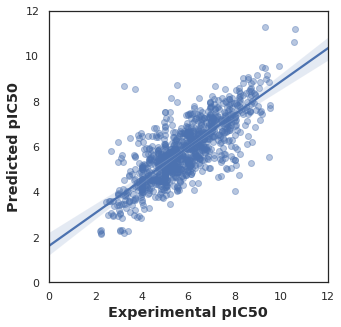

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show